### Imports

In [46]:
# Configure libraries

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

### Get the Data

In [47]:
# Reading the data

df = pd.read_csv('train.csv')
df_pred = pd.read_csv('test.csv')
df.head()

,Unnamed: 0,day,hour,geohash,n.total,n.uber,n.bike,n.green,n.yellow,lat,...,state,borough,hour.num,hour.cos,hour.sin,wday.num,wday.cos,wday.sin,prec.cat,log.total
0,1,1,0,dr5qu,4,0,0,3,1,40.583496,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.386294
1,2,1,0,dr5qv,4,0,0,4,0,40.583496,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.386294
2,3,1,0,dr5r5,7,1,0,5,1,40.627441,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.945910
3,4,1,0,dr5r7,1,0,0,0,1,40.671387,...,New York,NaN,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",1.000000
4,5,1,0,dr5re,672,15,7,0,650,40.715332,...,New York,NaN,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",7.510258


### Training and Testing Data

In [62]:
# Preparing training and testing data

y = np.log10(df['n.total']+1)
X = df[['day', 'hour', 'lat', 'long', 'wknd','hour.num', 'hour.cos', 'hour.sin', 
        'wday.num', 'wday.cos', 'wday.sin']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Tuning hyperparameters via gridsearch

In [63]:
%%time

# GridSearch: defining a grid of parameters over which to optimize the rf regressor

params = [{'n_estimators': [10,20,30,50], 
           'max_features': ['auto', 'sqrt', 'log2'], 
           'max_depth': [10, 30, 50, None], 
           'oob_score': [True, False]}]
rf = RandomForestRegressor(n_jobs = -1)

gs = GridSearchCV(rf, params, cv =10)
gs = gs.fit(X_train, y_train)

print('Best RSquared: %.3f' %gs.best_score_)
print(gs.best_params_)

//anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//an

Best RSquared: 0.983
{'max_features': 'auto', 'max_depth': 30, 'oob_score': True, 'n_estimators': 50}
CPU times: user 37min 11s, sys: 1min 29s, total: 38min 41s
Wall time: 15min 27s


In [64]:
print('Best Train R-Squared: %.03f' %gs.best_score_)
print('Best parameters: ', gs.best_params_)
print('Best Estimator:', gs.best_estimator_)

Best Train R-Squared: 0.983
Best parameters:  {'max_features': 'auto', 'max_depth': 30, 'oob_score': True, 'n_estimators': 50}
Best Estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)


In [65]:
rf_b = gs.best_estimator_
rf_b.fit(X_train, y_train)
predictions_b = rf_b.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions_b))
print('MSE:', metrics.mean_squared_error(y_test, predictions_b))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_b)))
print('RSquared', metrics.explained_variance_score(y_test, predictions_b))

MAE: 0.0928047220443
MSE: 0.0179237592138
RMSE: 0.133879644509
RSquared 0.982859234151


In [66]:
print('Best Train R-Squared: %.03f' %gs.best_score_)
print('Test R-Squared: %0.3f' %rf_b.score(X_test, y_test))

Best Train R-Squared: 0.983
Test R-Squared: 0.983


### Evaluating results

In [67]:
# Show some of the predictions vs. real number of trips
pd.DataFrame(np.round(np.power(10, np.column_stack((predictions_b, y_test))) - 1, decimals = 0).astype(int)).head(10)        

,0,1
0,8295,10834
1,1271,1232
2,201,185
3,8,11
4,65,72
5,25,31
6,5,3
7,6,2
8,7,10
9,2086,2177


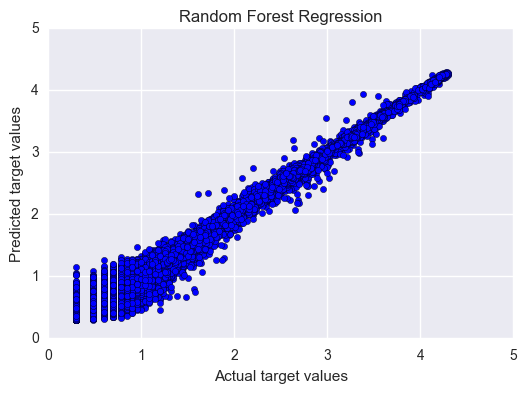

In [83]:
# Create a scatterplot of real test values vs. predicted ones
plt.scatter(y_test, predictions_b)
plt.title('Random Forest Regression')
plt.xlabel('Actual target values')
plt.ylabel('Predicted target values')
plt.savefig('rf.png')

(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   7.00000000e+00,   1.40000000e+01,
          1.50000000e+01,   2.90000000e+01,   3.80000000e+01,
          5.00000000e+01,   6.50000000e+01,   7.80000000e+01,
          1.09000000e+02,   1.48000000e+02,   1.94000000e+02,
          2.75000000e+02,   3.69000000e+02,   5.35000000e+02,
          6.93000000e+02,   1.08100000e+03,   1.55000000e+03,
          2.60700000e+03,   3.04500000e+03,   1.94300000e+03,
          1.27400000e+03,   9.17000000e+02,   6.54000000e+02,
          4.76000000e+02,   3.22000000e+02,   2.39000000e+02,
          1.88000000e+02,   1.28000000e+02,   7.50000000e+01,
          5.10000000e+01,   3.30000000e+01,   2.50000000e+01,
          1.50000000e+01,   1.10000000e+01,   7.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

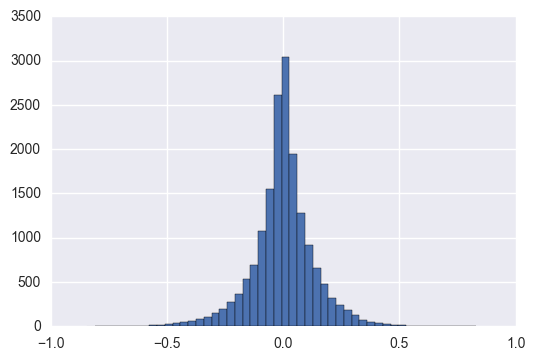

In [69]:
# Plotting a histogram of the residuals - are they normally distributed?
plt.hist((y_test-predictions_b), bins = 50)

### Analyzing the Results

In [70]:
# What are the most important features?
import operator
dict_feat_imp = dict(zip(list(X_train.columns.values),rf_b.feature_importances_))
sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('long', 0.48384413925168196),
 ('lat', 0.44411771819839452),
 ('hour', 0.017350698660462804),
 ('hour.num', 0.016508531816869839),
 ('day', 0.0086690420665314523),
 ('hour.sin', 0.0082004937374973632),
 ('hour.cos', 0.007712119520906586),
 ('wday.num', 0.0061204417277882783),
 ('wknd', 0.0035968322135668013),
 ('wday.sin', 0.0024205170463353506),
 ('wday.cos', 0.0014594657599650942)]

In [71]:
s = pd.DataFrame(sorted_features)
s

,0,1
0,long,0.483844
1,lat,0.444118
2,hour,0.017351
3,hour.num,0.016509
4,day,0.008669
5,hour.sin,0.008200
6,hour.cos,0.007712
7,wday.num,0.006120
8,wknd,0.003597
9,wday.sin,0.002421


Latitude and longitude are by far the most important factors influencing the number of trips. After than come time of the day, day of the week, and whether the day is a weekend or not. The average daily temperature appears to be a more important weather factor than daily precipiation summaries.

### Evaluating the Model

In [73]:
from sklearn import metrics

In [74]:
print('MAE ', metrics.mean_absolute_error(y_test, predictions_b))
print('MSE ', metrics.mean_squared_error(y_test, predictions_b))
print('RMSE ', np.sqrt(metrics.mean_squared_error(y_test, predictions_b)), ' (This is in log-space!)')
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_b))
print('So two thirds of the records would be a factor of less than %0.2f away from the real value' % np.power(10, rmse))

MAE  0.0928047220443
MSE  0.0179237592138
RMSE  0.133879644509  (This is in log-space!)
So two thirds of the records would be a factor of less than 1.36 away from the real value


In [75]:
print('RSquared', metrics.explained_variance_score(y_test, predictions_b))

RSquared 0.982859234151


### Creating predicted dataset

In [76]:
# Dataframe for prediction

X_pred = df_pred[['day', 'hour', 'lat', 'long', 'wknd','hour.num', 'hour.cos', 'hour.sin', 
        'wday.num', 'wday.cos', 'wday.sin']]

# Predicting into the 'future'
X_pred['n.pred'] = np.round(np.power(10, rf_b.predict(X_pred)) - 1, decimals = 0)
X_pred.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,day,hour,lat,long,wknd,hour.num,hour.cos,hour.sin,wday.num,wday.cos,wday.sin,n.pred
0,24,0,40.583496,-73.981934,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,4.0
1,24,0,40.583496,-73.937988,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0
2,24,0,40.627441,-74.157715,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,1.0
3,24,0,40.627441,-74.025879,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0
4,24,0,40.671387,-74.025879,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0


In [77]:
# Selecting real number of pickups to merge with predictions 

real_y = df_pred[['wday', 'geohash', 'day', 'n.total', 'lat', 'long', 'hour']]
real_y.head()

,wday,geohash,day,n.total,lat,long,hour
0,Tuesday,dr5qu,24,2,40.583496,-73.981934,0
1,Tuesday,dr5qv,24,5,40.583496,-73.937988,0
2,Tuesday,dr5r0,24,1,40.627441,-74.157715,0
3,Tuesday,dr5r5,24,7,40.627441,-74.025879,0
4,Tuesday,dr5r7,24,3,40.671387,-74.025879,0


In [78]:
X_pred = pd.merge(X_pred, real_y, how = 'left', on = ['day', 'hour', 'lat', 'long'])
X_pred.head()

,day,hour,lat,long,wknd,hour.num,hour.cos,hour.sin,wday.num,wday.cos,wday.sin,n.pred,wday,geohash,n.total
0,24,0,40.583496,-73.981934,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,4.0,Tuesday,dr5qu,2
1,24,0,40.583496,-73.937988,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0,Tuesday,dr5qv,5
2,24,0,40.627441,-74.157715,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,1.0,Tuesday,dr5r0,1
3,24,0,40.627441,-74.025879,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0,Tuesday,dr5r5,7
4,24,0,40.671387,-74.025879,0,0.0,1.0,0.0,0.285714,-0.222521,0.974928,6.0,Tuesday,dr5r7,3


In [79]:
# Retain only colums useful for the web application

X_pred = X_pred.drop(['wknd','hour.num','hour.cos','hour.sin','wday.num',
                      'wday.cos','wday.sin'],
                     axis = 1)

In [80]:
X_pred.tail()

,day,hour,lat,long,n.pred,wday,geohash,n.total
4833,30,23,40.847168,-73.937988,151.0,Monday,dr72m,168
4834,30,23,40.803223,-73.894043,5.0,Monday,dr72n,12
4835,30,23,40.847168,-73.894043,32.0,Monday,dr72q,30
4836,30,23,40.847168,-73.850098,15.0,Monday,dr72r,10
4837,30,23,40.891113,-73.850098,3.0,Monday,dr72x,1


In [81]:
# Write to csv
X_pred.to_csv('trip_data_prediction_p5_24_30_Jun.csv')